In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

#### Data Preparation

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-14 20:51:29--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M   154KB/s    in 9.7s    

2022-10-14 20:51:39 (144 KB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [3]:
data = pd.read_csv('housing.csv')

In [4]:
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
columns = [
    'latitude','longitude','housing_median_age','total_rooms',
    'total_bedrooms','population','households','median_income',
    'median_house_value','ocean_proximity'
    ]

In [6]:
df = data[columns]

In [7]:
df = df.fillna(0)

In [8]:
df.isna().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [9]:
df.median_house_value = np.log1p(df.median_house_value)

In [10]:
df

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,39.48,-121.09,25.0,1665.0,374.0,845.0,330.0,1.5603,11.265758,INLAND
20636,39.49,-121.21,18.0,697.0,150.0,356.0,114.0,2.5568,11.252872,INLAND
20637,39.43,-121.22,17.0,2254.0,485.0,1007.0,433.0,1.7000,11.432810,INLAND
20638,39.43,-121.32,18.0,1860.0,409.0,741.0,349.0,1.8672,11.346883,INLAND


### Split the data into train, test, and split sets

In [11]:
df_fulltrain, df_test = train_test_split(df, test_size=0.2, random_state = 1)
df_train, df_val = train_test_split(df, test_size = 0.25, random_state = 1)

In [12]:
df_fulltrain.reset_index(drop = True, inplace = True)
df_train.reset_index(drop = True, inplace = True)
df_val.reset_index(drop=True, inplace = True)
df_test.reset_index(drop=True, inplace = True)

y_fulltrain = df_fulltrain['median_house_value']
y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']

del df_fulltrain['median_house_value']
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [13]:
from sklearn.feature_extraction import DictVectorizer

In [14]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND`
* `total_rooms`
* `latitude`
* `population`


In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score

In [16]:
dt = DecisionTreeRegressor(max_depth = 1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [17]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/chanchan/Documents/data_projects/ml_zoomcamp/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Answer: ocean_proximity=INLAND

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* 0.25
* 0.55
* 0.85

In [18]:
rf = RandomForestRegressor(n_estimators=10, random_state = 1, n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
y_pred = rf.predict(X_val)

In [20]:
rmse = mean_squared_error(y_val, y_pred)
rmse

0.05944212779505333

Answer: 0.05

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 55
- 75
- 150

In [21]:
n_estimators = range(10,201,10)
score = []
for c in n_estimators:
    rf = RandomForestRegressor(n_estimators=c, random_state = 1, n_jobs = -1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)
    
    score.append(rmse)

In [22]:
rf_scores = pd.DataFrame({'n_estimators': n_estimators, 'score': score})

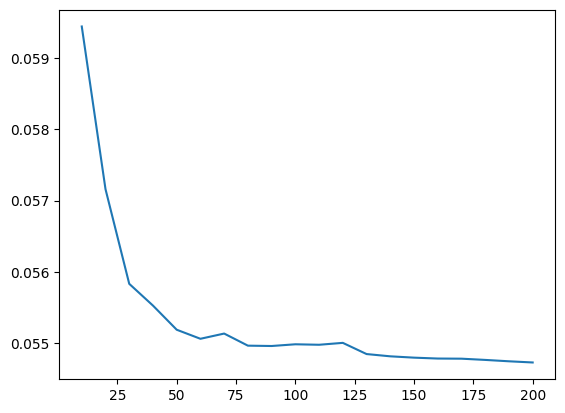

In [23]:
plt.plot(rf_scores['n_estimators'],rf_scores['score'], label = 'score')

In [24]:
rf_scores

,n_estimators,score
0,10,0.059442
1,20,0.057160
2,30,0.055831
3,40,0.055526
4,50,0.055187
5,60,0.055060
6,70,0.055133
7,80,0.054963
8,90,0.054959
9,100,0.054983


Answer: 75

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [25]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
rf_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
rf_scores

,max_depth,n_estimators,rmse
0,10,10,0.257955
1,10,20,0.256396
2,10,30,0.255496
3,10,40,0.255036
4,10,50,0.254825
...,...,...,...
75,25,160,0.234324
76,25,170,0.234380
77,25,180,0.234345
78,25,190,0.234292


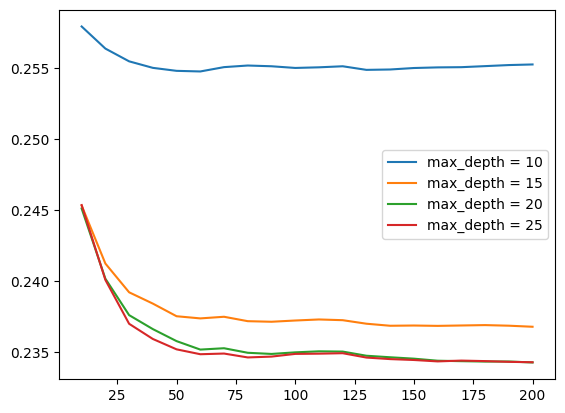

In [27]:
for d in [10,15,20,25]:
    plt.plot(rf_scores[rf_scores['max_depth'] == d].n_estimators ,
             rf_scores[rf_scores['max_depth'] == d].rmse,
             label = f'max_depth = {d}')
    
plt.legend()
#plt.ylim(0, 0.250)

Answer: 20

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`

In [28]:
rf = RandomForestRegressor(n_estimators=10, 
                           max_depth = 20, 
                           random_state = 1, 
                           n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [29]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

/home/chanchan/Documents/data_projects/ml_zoomcamp/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


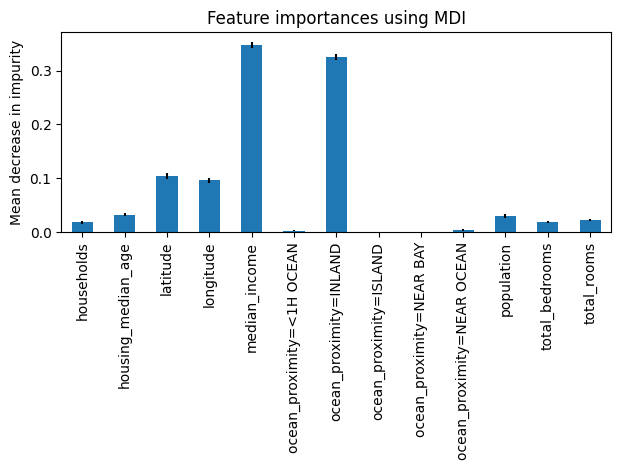

In [30]:
forest_importances = pd.Series(importances, index=dv.get_feature_names())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [31]:
features = dv.get_feature_names()

/home/chanchan/Documents/data_projects/ml_zoomcamp/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
df_importances = pd.DataFrame()
df_importances['feature'] = features
df_importances['importance'] = importances
df_importances

,feature,importance
0,households,0.017933
1,housing_median_age,0.032022
2,latitude,0.103794
3,longitude,0.095964
4,median_income,0.347275
5,ocean_proximity=<1H OCEAN,0.002269
6,ocean_proximity=INLAND,0.325677
7,ocean_proximity=ISLAND,0.000097
8,ocean_proximity=NEAR BAY,0.000295
9,ocean_proximity=NEAR OCEAN,0.003915


In [33]:
df_importances.sort_values(by = 'importance', ascending = False)

,feature,importance
4,median_income,0.347275
6,ocean_proximity=INLAND,0.325677
2,latitude,0.103794
3,longitude,0.095964
1,housing_median_age,0.032022
10,population,0.029970
12,total_rooms,0.022227
11,total_bedrooms,0.018562
0,households,0.017933
9,ocean_proximity=NEAR OCEAN,0.003915


Answer: median_income

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` first to `0.1` and then to `0.01`

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same


In [34]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

features = dv.get_feature_names()
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

/home/chanchan/Documents/data_projects/ml_zoomcamp/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [40]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [41]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [42]:
scores = {}

In [43]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [44]:
scores['eta=0.3'] = parse_xgb_output(output)

In [45]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [46]:
scores['eta=0.1'] = parse_xgb_output(output)

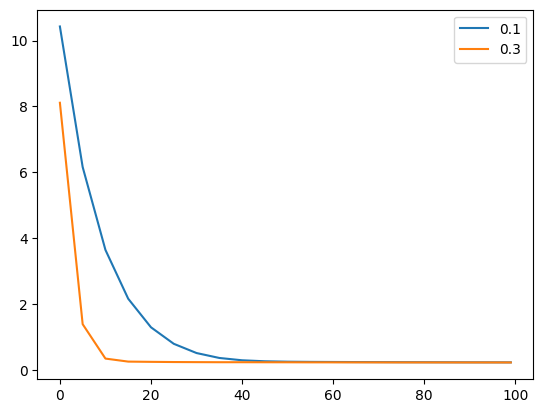

In [49]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()

Answer 0.3